Convolutional neural networks, have internal structures that are designed to operate upon two-dimensional image data, and as such preserve the spatial relationships for what was learned by the model. Specifically, the two-dimensional filters learned by the model can be inspected and visualized to discover the types of features that the model will detect, and the activation maps output by convolutional layers can be inspected to understand exactly what features were detected for a given input image.

After completing this tutorial, you will know:

* How to develop a visualization for specific filters in a convolutional neural network.
* How to develop a visualization for specific feature maps in a convolutional neural network.
* How to systematically visualize feature maps for each block in a deep convolutional neural network.

# Tutorial Overview

1. Visualizing Convolutional Layers
2. Pre-fit VGG Model
3. How to Visualize Filters
4. How to Visualize Feature Maps

# Visualizing Convolutional Layers
Neural network models are generally referred to as being opaque. This means that they are poor at explaining the reason why a specific decision or prediction was made.

Convolutional neural networks are designed to work with image data, and their structure and function suggest that should be less inscrutable than other types of neural networks.

Specifically, the models are comprised of small linear filters and the result of applying filters called activation maps, or more generally, feature maps.

Both filters and feature maps can be visualized.

For example, we can design and understand small filters, such as line detectors. Perhaps visualizing the filters within a learned convolutional neural network can provide insight into how the model works.

The feature maps that result from applying filters to input images and to feature maps output by prior layers could provide insight into the internal representation that the model has of a specific input at a given point in the model.

In [2]:
 # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
from matplotlib import pyplot

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import os
import matplotlib
#import seaborn as sns
import matplotlib.pyplot as plt
#from tqdm import tqdm_notebook
%matplotlib inline 
import cv2 as cv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential 
from keras.layers import Conv2D,MaxPool2D,DepthwiseConv2D,Flatten,Dense,Dropout,AveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import to_categorical

Using TensorFlow backend.


In [30]:
#Load the model
model = tf.keras.models.load_model("m2.h5")

# Summary of the model
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 512, 512, 32)      896       
_________________________________________________________________
batch_normalization_25 (Batc (None, 512, 512, 32)      128       
_________________________________________________________________
depthwise_conv2d_9 (Depthwis (None, 256, 256, 32)      160       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 128, 128, 64)    

# HOW TO VISUALIZE 

In neural network terminology, the learned filters are simply weights, yet because of the specialized two-dimensional structure of the filters, the weight values have a spatial relationship to each other and plotting each filter as a two-dimensional image is meaningful (or could be).

The model summary printed in the previous section summarizes the output shape of each layer, e.g. the shape of the resulting feature maps. It does not give any idea of the shape of the filters (weights) in the network, only the total number of weights per layer.

We can access all of the layers of the model via the **model.layers** property.

Each layer has a layer.name property, where the convolutional layers have a naming convolution like **block#_conv#**, where the ‘#‘ is an integer. Therefore, we can check the name of each layer and skip any that don’t contain the string ‘conv‘.

* Each convolutional layer has two sets of weights.

One is the block of filters and the other is the block of bias values. These are accessible via the **layer.get_weights()** function. We can retrieve these weights and then summarize their shape.


In [5]:
for layer in model.layers:
    
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

conv2d_39 (3, 3, 3, 32)
depthwise_conv2d_9 (2, 2, 32, 1)
conv2d_40 (3, 3, 32, 32)
conv2d_41 (3, 3, 32, 32)
conv2d_42 (3, 3, 32, 64)
depthwise_conv2d_10 (2, 2, 64, 1)
conv2d_43 (3, 3, 64, 128)
conv2d_44 (3, 3, 128, 256)


We see each layer has 3x3 filters.

We can see that for the input image with three channels for red, green and blue, that each filter has a depth of three (here we are working with a channel-last format). We could visualize one filter as a plot with three images, one for each channel, or compress all three down to a single color image, or even just look at the first channel and assume the other channels will look the same. The problem is, we then have 63 other filters that we might like to visualize.

We can retrieve the filters from the first layer as follows:

In [10]:
# retrieve weights from the second hidden layer
filters,bias = model.layers[2].get_weights()

The weight values will likely be small positive and negative values centered around 0.0.

We can normalize their values to the range 0-1 to make them easy to visualize.

In [11]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [13]:
filters.shape

(2, 2, 32, 1)

In [17]:
filters[:,:,1]

array([[[0.9253771 ],
        [0.09586118]],

       [[0.21074145],
        [0.64833546]]], dtype=float32)

In [42]:
n_filters=32
for i in range(n_filters):
    # get the filters
    f = filters[:,:,i]
    pyplot.subplot(4,4,i/8)
    pyplot.imshow(f,cmap='gray')
pyplot.show()

ValueError: num must be 1 <= num <= 16, not 0

<Figure size 432x288 with 0 Axes>

We can see that in some cases, the filter is the same across the channels (the first row), and in others, the filters differ (the last row).

The dark squares indicate small or inhibitory weights and the light squares represent large or excitatory weights. Using this intuition, we can see that the filters on the first row detect a gradient from light in the top left to dark in the bottom right.

### Note:
* Although we have a visualization, we only see the first six of the 64 filters in the first convolutional layer. Visualizing all 64 filters in one image is feasible.

* Sadly, this does not scale; if we wish to start looking at filters in the second convolutional layer, we can see that again we have 64 filters, but each has 64 channels to match the input feature maps. To see all 64 channels in a row for all 64 filters would require (64×64) 4,096 subplots in which it may be challenging to see any detail.

# How to Visualize Feature Maps

The activation maps, called feature maps, capture the result of applying the filters to input, such as the input image or another feature map.

The idea of visualizing a feature map for a specific input image would be to understand what features of the input are detected or preserved in the feature maps. The expectation would be that the feature maps close to the input detect small or fine-grained detail, whereas feature maps close to the output of the model capture more general features.

For the input I will be using an image of my childhood crush Hermoine Granger(Emma Watson).

### Note:

we need a clearer idea of the shape of the feature maps output by each of the convolutional layers and the layer index number so that we can retrieve the appropriate layer output.

In [22]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

0 conv2d_39 (None, 512, 512, 32)
2 depthwise_conv2d_9 (None, 256, 256, 32)
3 conv2d_40 (None, 256, 256, 32)
4 conv2d_41 (None, 256, 256, 32)
6 conv2d_42 (None, 128, 128, 64)
8 depthwise_conv2d_10 (None, 64, 64, 64)
9 conv2d_43 (None, 64, 64, 128)
11 conv2d_44 (None, 32, 32, 256)


In [24]:
image = load_img("0.png" , target_size=(512,512))

# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = expand_dims(image, axis=0)

The pixel values then need to be scaled appropriately for the VGG model.

In [32]:
model.layers

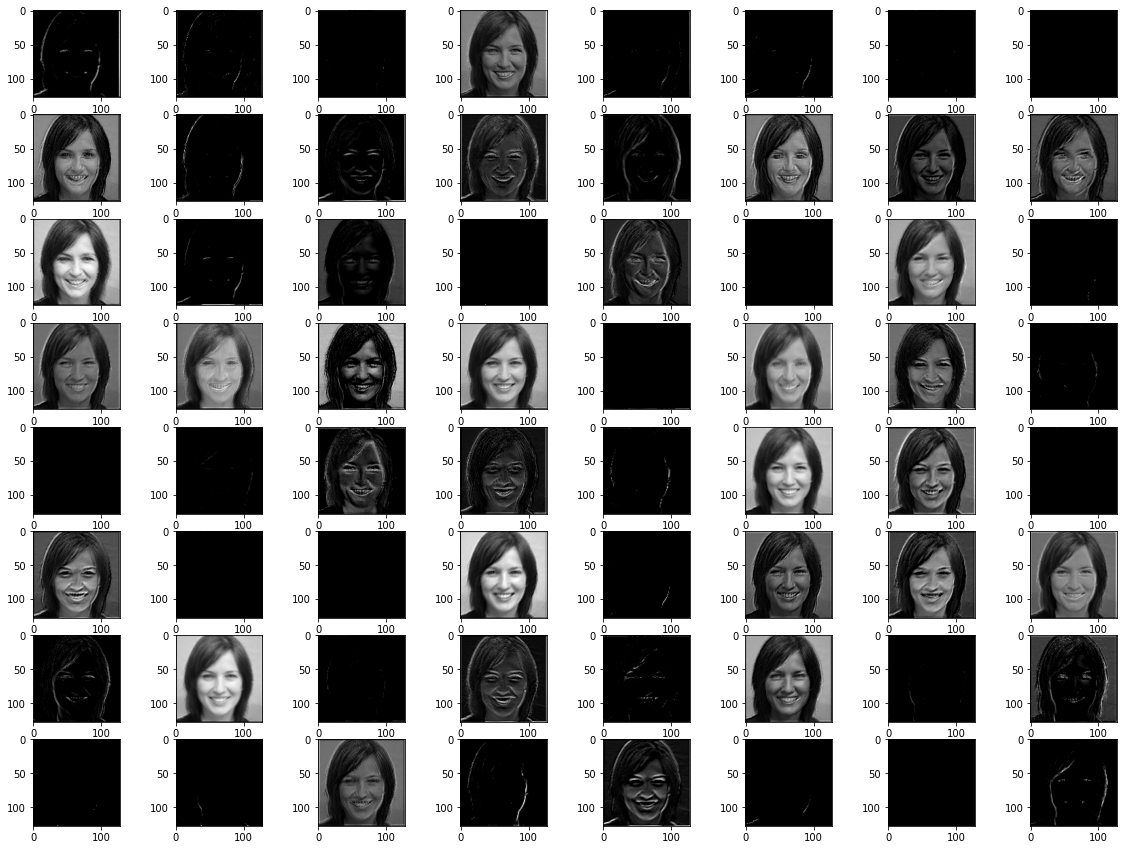

In [34]:
m = Model(inputs=model.inputs , outputs=model.layers[6].output)
#calculating features_map
features = m.predict(image)
fig = pyplot.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    pyplot.subplot(8,8,i)
    pyplot.imshow(features[0,:,:,i-1] , cmap='gray')
    
pyplot.show()

Now we will visualise features of other layers.

In [35]:
model2 = tf.keras.models.load_model("m2.h5")

In [50]:
blocks = [7]
outputs = [model2.layers[i].output for i in blocks]

model2 = Model( inputs= model2.inputs, outputs = outputs)

In [ ]:
feature_map = model2.predict(image)

for i,fmap in zip(blocks,feature_map):
    fig = pyplot.figure(figsize=(20,15))
    #https://stackoverflow.com/a/12444777
    fig.suptitle("BLOCK_{}".format(i) , fontsize=20)
    for i in range(1,features.shape[3]+1):
        pyplot.subplot(8,8,i)
        pyplot.imshow(fmap[:,:,i-1] , cmap='gray')
        #print(fmap[:,:,i].shape)
    
pyplot.show()

In [ ]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

# Utility to search for layer index by name.
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

# This is the output node we want to maximize.
filter_idx = 0
img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
plt.imshow(img[..., 0])